In [283]:
import cv2
from skan import Skeleton, summarize
from skan.csr import skeleton_to_csgraph
import networkx as nx
import os
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
import numpy as np
import networkx as nx

In [289]:
def loader(mask_dir):
    masks = []  # Initialize an empty list to store images

    # Looping through the images in the image directory
    for image_filename in os.listdir(mask_dir):
        if image_filename.endswith(".png"):
            mask_path = os.path.join(mask_dir, image_filename)
            mask = cv2.imread(mask_path, 0)
            masks.append(mask)
            

    return masks

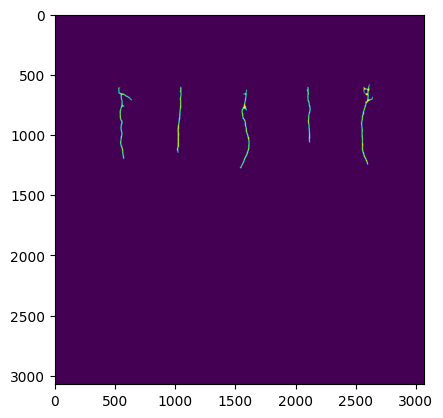

In [290]:
mask_dir = r"C:\Users\benjm\Downloads\Workspace\final\task_5ed"
masks = loader(mask_dir)
plt.imshow(masks[0])

In [293]:
skeletonized = []

for index, mask in enumerate(masks):
    _, binary_image = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    skelmask = skeletonize(binary_image)
    skeletonized.append(skelmask)
    print(index)

0
1
2
3
4
5
6
7
8
9
10


In [295]:
simple_skeleton_branch_data = {}
for i, skel in enumerate(skeletonized):
    if not np.any(skel):  # Check if the image is not all zeros
        print(f"Skeletonized image at index {i} is empty.")
    else:
        # Process non-empty skeletons
        simple_skeleton_branch_data[i] = summarize(Skeleton(skel))
        simple_skeleton_branch_data[i].sort_values(by="branch-distance", ascending=False)

Skeletonized image at index 6 is empty.
Skeletonized image at index 7 is empty.


In [317]:
def assign_plant_id(x_coordinate):
    if x_coordinate < 750:
        return 1
    elif x_coordinate < 1250:
        return 2
    elif x_coordinate < 1750:
        return 3
    elif x_coordinate < 2250:
        return 4
    else:
        return 5

In [331]:
import csv

def draw_main_root(image, skeleton_branch_data, u):
    info_image = np.copy(image).astype(np.uint8)  # Convert to uint8 if needed
    info_image *= 255
    main_root_lengths = {}
    lateral_root_lengths = {}

    for skeleton_id, group in skeleton_branch_data.groupby('skeleton-id'):
        G = nx.Graph()
        lateral_root_lengths[skeleton_id] = []
        
        # Add edges based on branch data, with actual lengths as weights
        for index, row in group.iterrows():
            src = (int(row['image-coord-src-1']), int(row['image-coord-src-0']))
            dst = (int(row['image-coord-dst-1']), int(row['image-coord-dst-0']))
            length = row['branch-distance']  # The actual length of the branch segment
            G.add_edge(src, dst, weight=length)

        endpoints = [node for node, degree in G.degree() if degree == 1]
        topmost_point = min(G.nodes, key=lambda point: point[1])
        
        # Initialize variables to store the longest path
        longest_path = []
        max_path_length = 0

        # Find the longest path based on actual branch lengths
        for end_point in endpoints:
            if topmost_point != end_point:
                try:
                    length, path = nx.single_source_dijkstra(G, topmost_point, end_point, weight='weight')
                    if length > max_path_length:
                        longest_path = path
                        max_path_length = length
                except nx.NetworkXNoPath:
                    continue
        
        # Draw the longest path on the image
        for i in range(len(longest_path) - 1):
            point1 = longest_path[i]
            point2 = longest_path[i + 1]
            cv2.line(info_image, point1, point2, color=(255, 255, 0), thickness=2)

        plant_id = assign_plant_id(topmost_point[0])
        main_root_lengths[plant_id] = max_path_length
        
        for edge in G.edges(data=True):
            if not (edge[0] in longest_path and edge[1] in longest_path):
                lateral_length = edge[2]['weight']
                lateral_root_lengths[skeleton_id].append(lateral_length)

    for plant_id in range(1, 6):
        main_root_lengths.setdefault(plant_id, 0)
    
    sorted_main_root_lengths = dict(sorted(main_root_lengths.items()))
    for id, length in sorted_main_root_lengths.items():
        with open('export.csv', mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([f'test_image_{u+1}_plant_{id}', length])

    # Display the image with the longest paths drawn
    plt.figure(figsize=(12, 12))
    plt.imshow(info_image)
    plt.axis('off')
    plt.show()

    return main_root_lengths, lateral_root_lengths

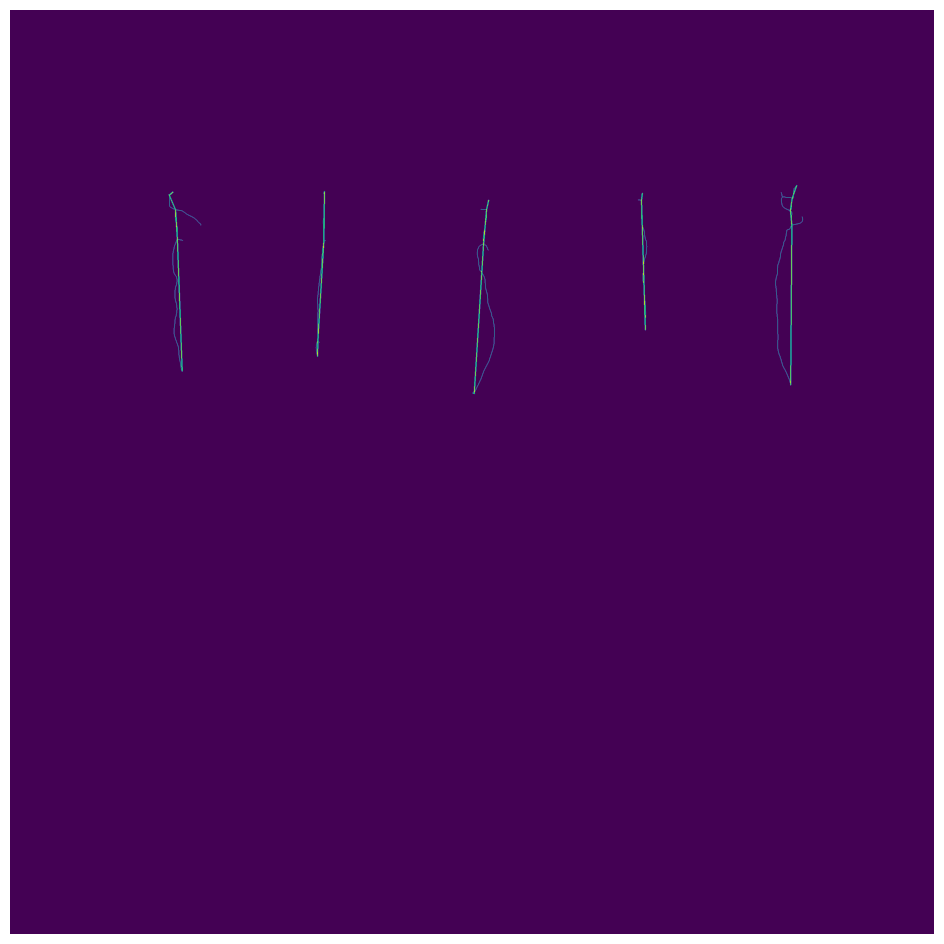

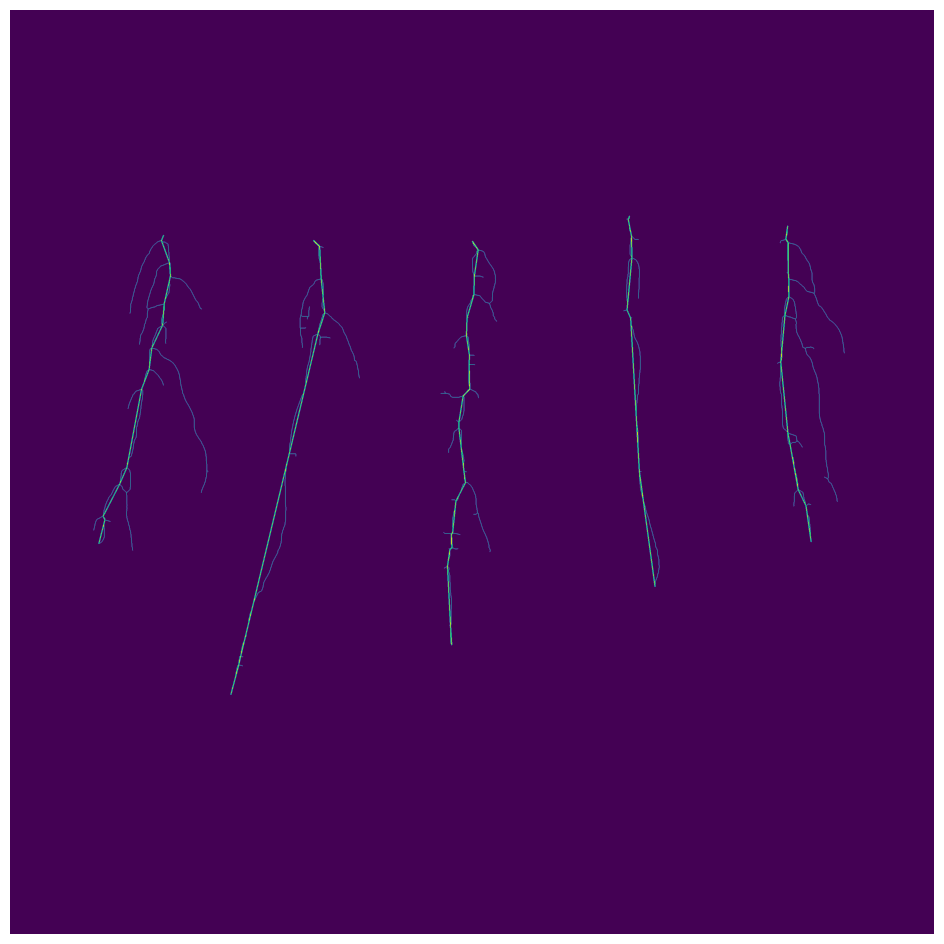

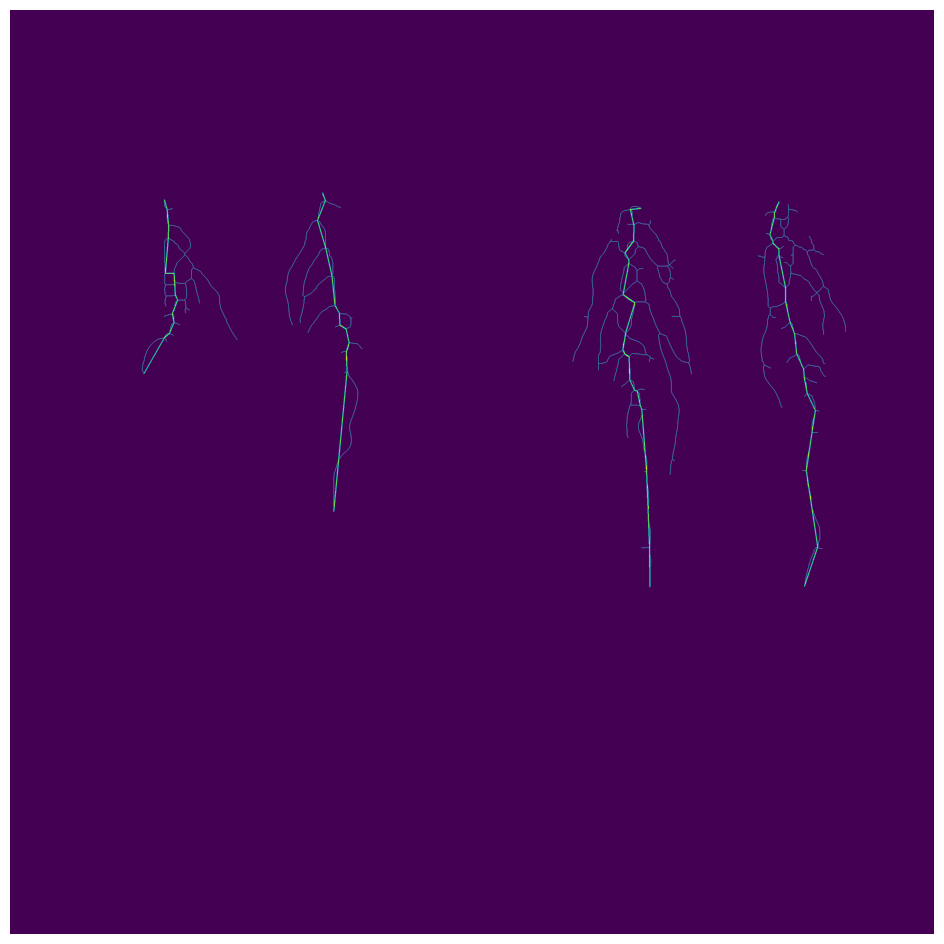

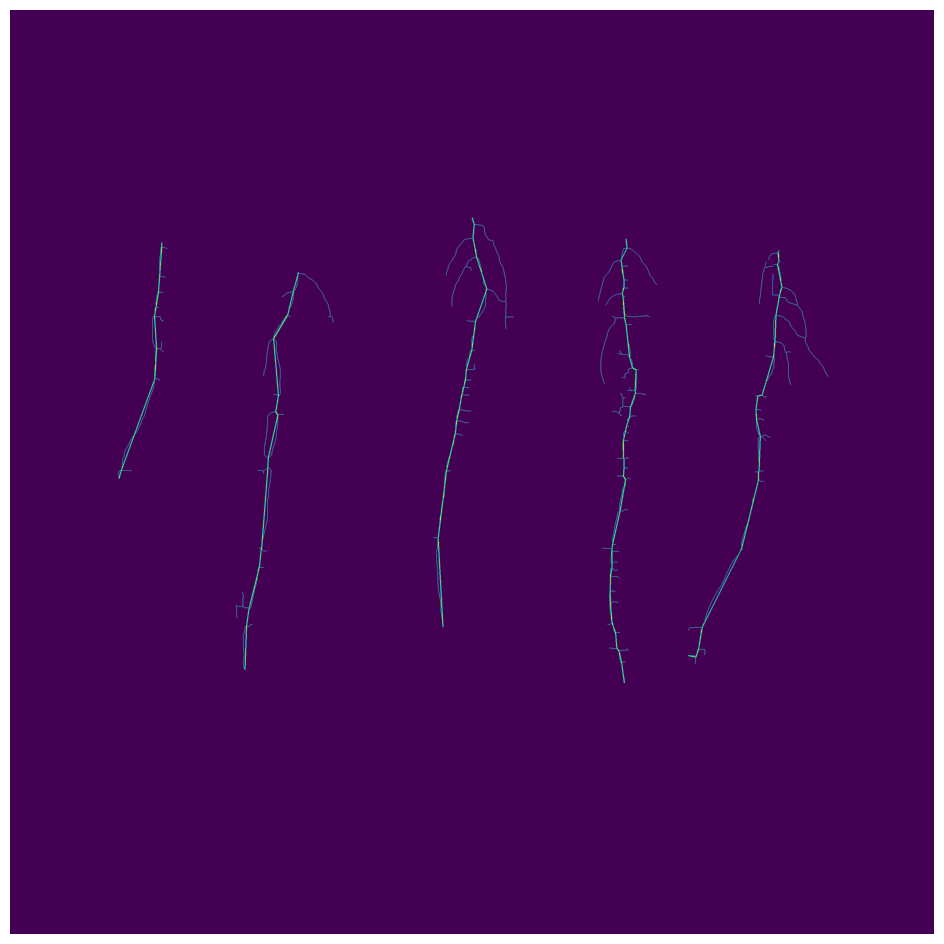

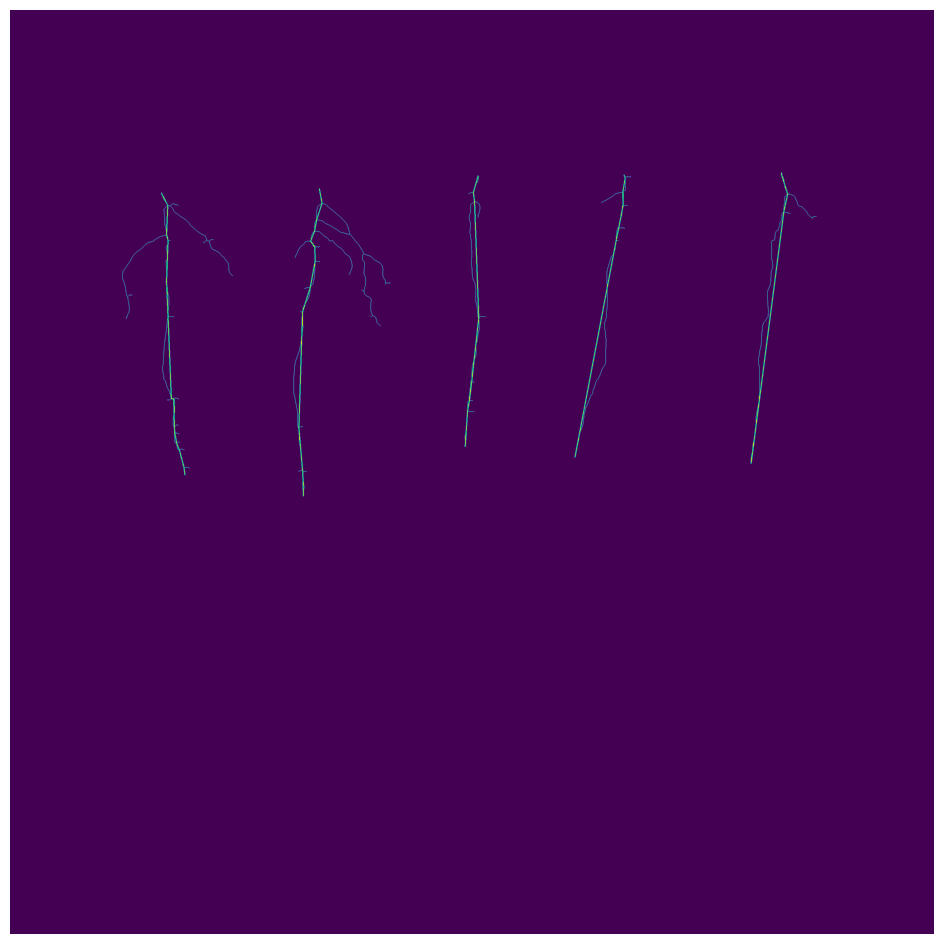

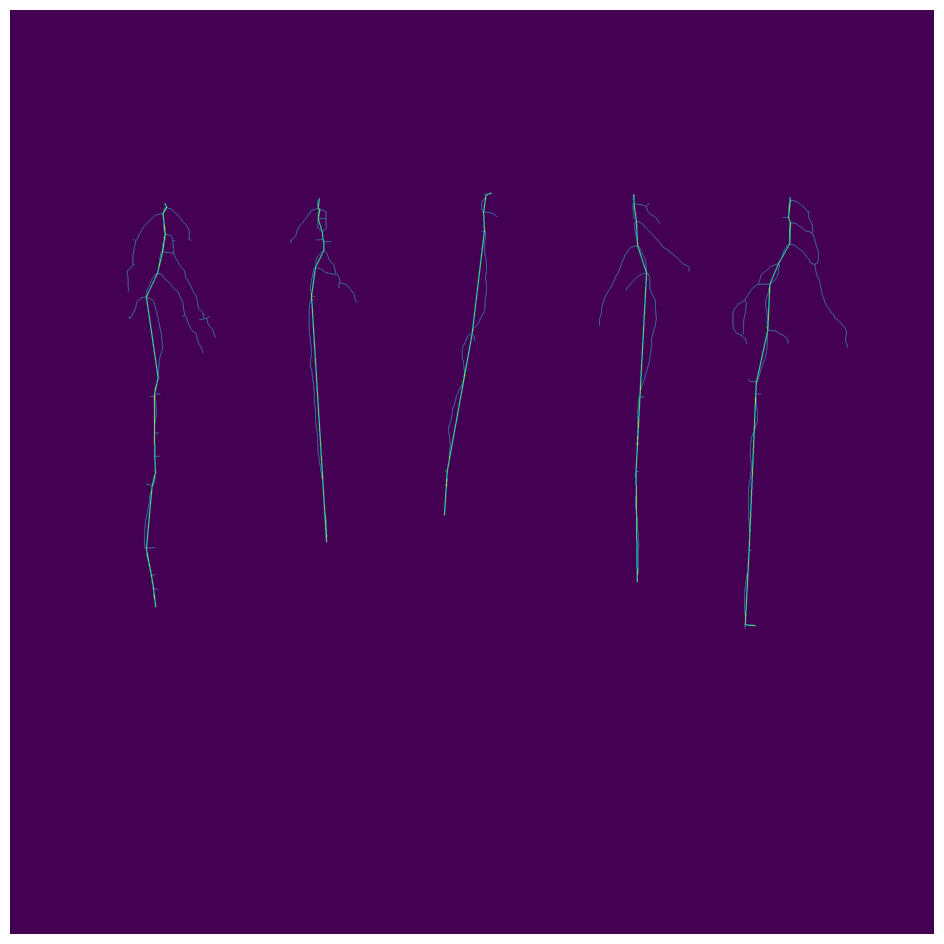

Skeletonized image at index 6 is empty.
Skeletonized image at index 7 is empty.


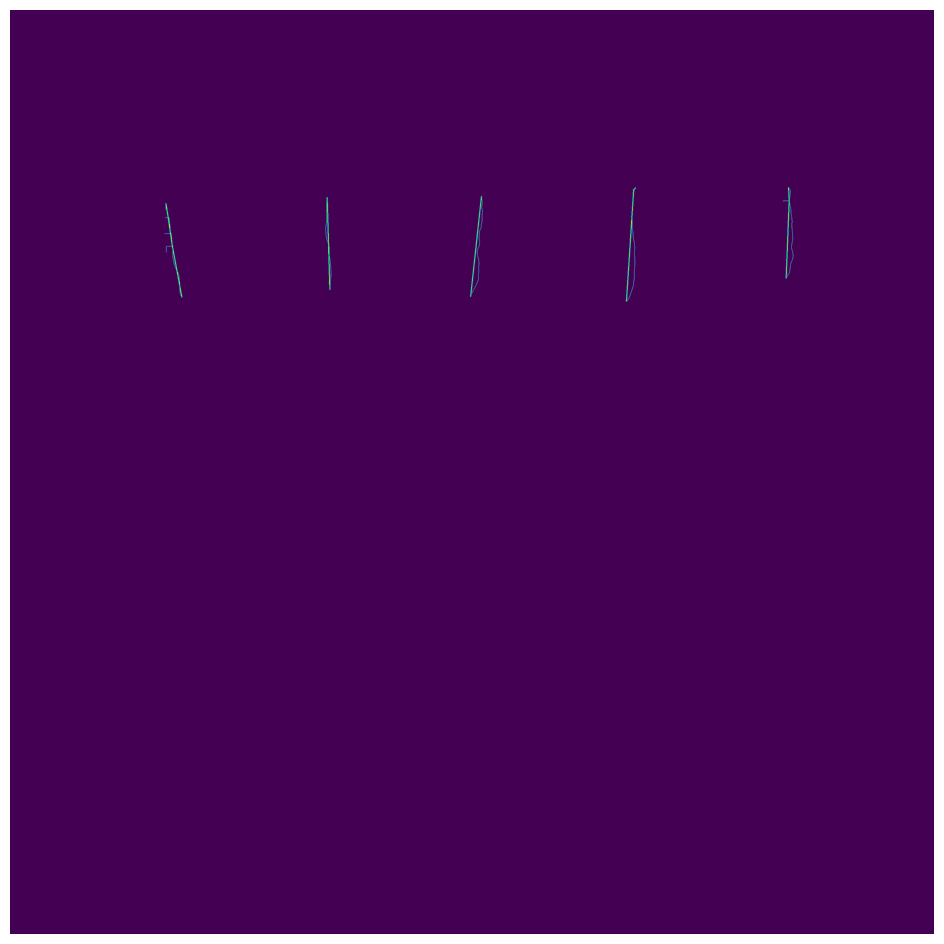

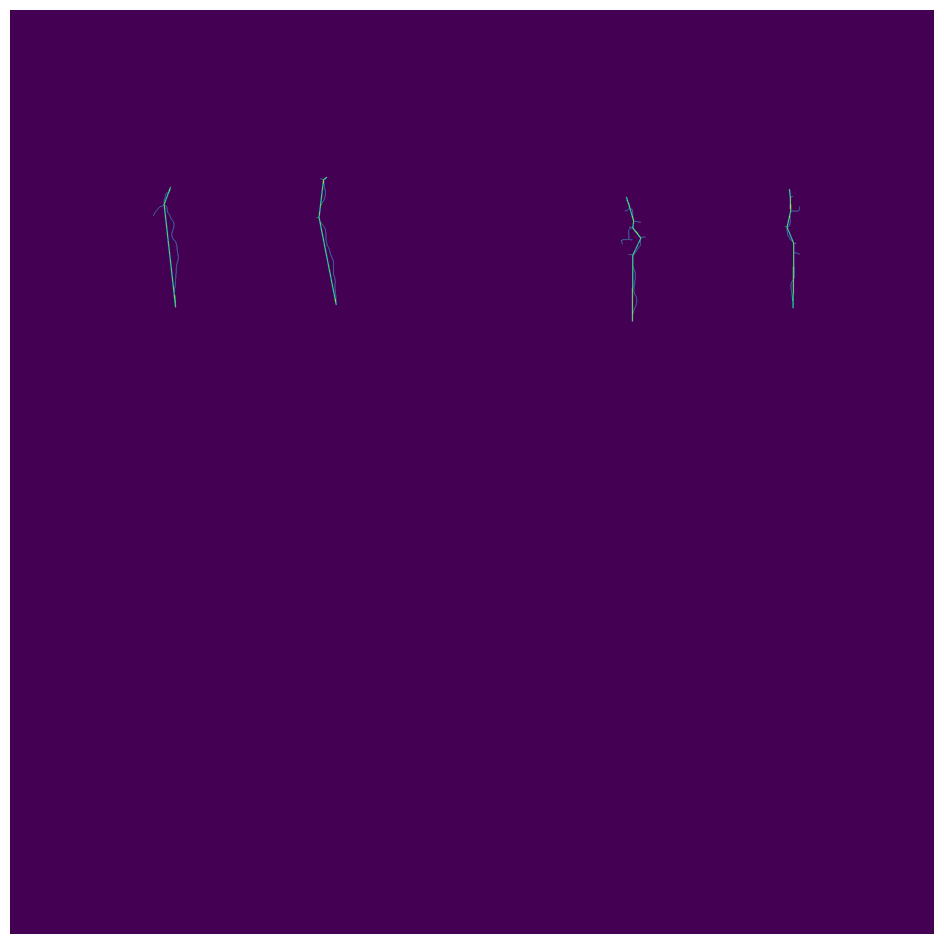

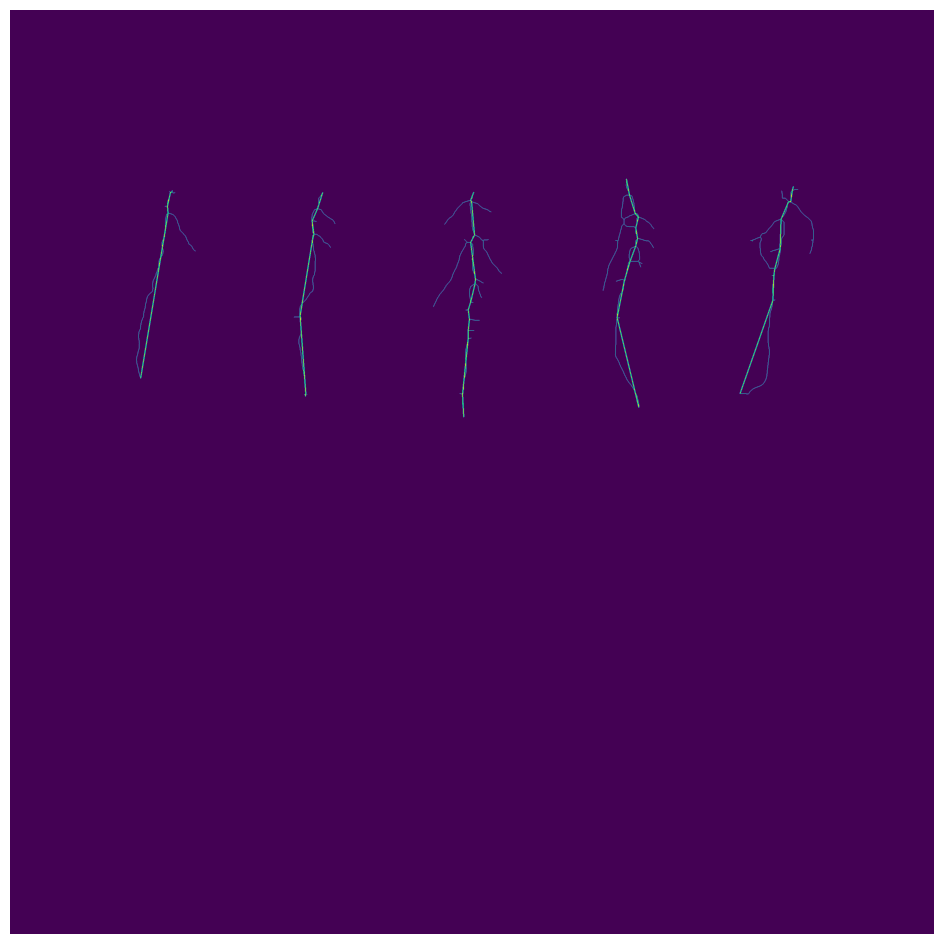

In [333]:
with open('export.csv', mode='w', newline='') as file:  # Use 'w' mode to write headers
    writer = csv.writer(file)
    writer.writerow(["Plant ID", "Length (px)"])

for i, image in enumerate(skeletonized):
    if not np.any(image):  # Check if the image is not all zeros
        print(f"Skeletonized image at index {i} is empty.")
    else:
        main_root_lengths, lateral_root_lengths = draw_main_root(image, simple_skeleton_branch_data[i], i)
        #for skeleton_id, lengths in lateral_root_lengths.items():
            #print(f"Lateral root lengths for skeleton {skeleton_id}: {lengths}")